In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import glob
import seaborn as sns
import os
import random
import cv2
from sklearn import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import xgboost as xgb
import joblib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
session = tf.Session(config=config)

# Creating static and local variables
SIZE = 256
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS = 3
n_classes = 8
EPOCHS = 100
BATCH_SIZE = 1
input_shape = (SIZE, SIZE, CHANNELS)


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
#--------------------Training
def training(path) : 
    # loading data from local directory -> basic method. here labels are folder name, means each variety of data stored in particular folder.
    train_images = []       # training dataset stored here...(numpy array form of images)
    train_labels = []     # labels will be stored here 
    
    '''here we are using glob for accessing directories'''
    path = path + '/*'
    for directory_path in glob.glob(path) :   
        label = directory_path.split('/')[-1]       # taking labels from folders
        # print(label)    # extracting label from directory path
        
        '''now we are entering into each folder and reading images from it and at a same 
        time we are also storing the label.'''
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) :    
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)    # read color image 
            img = cv2.resize(img, (SIZE, SIZE))        # resize the image
            
            '''actually cv2 read image in BGR channel ordering, in color image we have 3 channels
            RGB so here the channel order is different nothing special!. it doesnt affect on model.
            In reality we can arrange them in any order we like.'''
            cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            train_images.append(img)
            train_labels.append(label)
    
    # Shuffling the list to avoid the some kind of bias.
    train_data = list(zip(train_images, train_labels))
    '''Seed function is used to save the state of a random function, so that it can generate          
        same random numbers on multiple executions of the code on the same machine or on 
        different machines (for a specific seed value).'''
    random.seed(SEED_TRAINING)   
    random.shuffle(train_data)
    train_images, train_labels = zip(*train_data)   # it will unzip the ziped iterators, it will return tuple
    
    # converting tuples to numpy array.
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    
    # let's normalize our pixel values 
    train_images = train_images / 255.0
    return train_images, train_labels

In [7]:
def testing(path) : 
    test_images = []
    test_labels = []
    
    path = path + '/*'
    for directory_path in glob.glob(path) : 
        labels = directory_path.split('/')[-1]
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) : 
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (SIZE, SIZE))
            test_images.append(img)
            test_labels.append(labels)
            
    # Shuffling testing data
    test_data = list(zip(test_images, test_labels))
    random.seed(SEED_TESTING)
    random.shuffle(test_data)
    print(len(test_data))
    test_images, test_labels = zip(*test_data)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    # let's normalize our pixel values
    test_images = test_images / 255.0
    return test_images, test_labels


In [8]:
# preprocessing training and testing images
X_test, y_test_labels = testing(r'C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/6th sem/ML lab/tomato_disease_data/Test')
X_train, y_train_labels = training(r'C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/6th sem/ML lab/tomato_disease_data/Train')

1200


In [9]:
# encoding labels from text to integer
le = preprocessing.LabelEncoder()
le.fit(y_train_labels)
train_label_encoded = le.transform(y_train_labels)
le.fit(y_test_labels)
test_label_encoded = le.transform(y_test_labels)

# extracting original labels, later we will need it.
labels = dict(zip(le.classes_,range(len(le.classes_))))
print(labels)

# aliasing for better understanding
y_train, y_test = train_label_encoded, test_label_encoded

# let's load VGG16 Architecture without fully connected layers, considerding only fully convolutional layers
vgg_model = VGG16(weights = 'imagenet',  include_top = False, input_shape = (SIZE, SIZE, 3)) 

# let's make all layers non-trainable
for layer in vgg_model.layers : 
    layer.trainable = False
    
# now trainable parameter will be 0 in our architecture
vgg_model.summary()

# let's extract features from convolutional network for XBG
feature_extractor = vgg_model.predict(X_train)

# actually our data in the form of (2500, 8, 8, 512) into (2500, 8*8*512) 
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train_features = features

# perform same operation on test dataset
feature_extractor_test = vgg_model.predict(X_test)
features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
X_test_features = features_test


{'Test\\Tomato_Bacterial_spot': 0, 'Test\\Tomato_Early_blight': 1, 'Test\\Tomato_Late_blight': 2, 'Test\\Tomato_Leaf_Mold': 3, 'Test\\Tomato_Septoria_leaf_spot': 4, 'Test\\Tomato_Spider_mites_Two_spotted_spider_mite': 5, 'Test\\Tomato__Tomato_YellowLeaf__Curl_Virus': 6, 'Test\\Tomato_healthy': 7}
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)      

C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
# defining Random Forest Classifier Model
rfc = RandomForestClassifier() 
rfc.fit(X_train_features, y_train)
rfc_pred = rfc.predict(X_test_features)

# inversing le transforme to get original labels
rfc_pred = le.inverse_transform(rfc_pred)

# checking overall accuracy
print('Accuracy of Random Forest : ', metrics.accuracy_score(y_test_labels, rfc_pred))


In [7]:
joblib.dump(rfc, 'hybrid_model_rfc.pkl')

['hybrid_model_rfc.pkl']

In [9]:
# defining XGBoost Classifier model      ----- Model trained in just 7 minutes(CPU)
model = xgb.XGBClassifier(use_label_encoder = False)
model.fit(X_train_features, y_train)
xgb_pred = model.predict(X_test_features)

# inversing le transforme to get original labels
xgb_pred = le.inverse_transform(xgb_pred)

# let's check overall accuracy
print('Accuracy of XGBOOST : ', metrics.accuracy_score(y_test_labels, xgb_pred))
# '''
# Accuracy of XGBOOST :  0.897
# '''

[22:49:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBOOST :  0.8616666666666667


Text(0.5, 1.0, 'Random Forest Preformance')

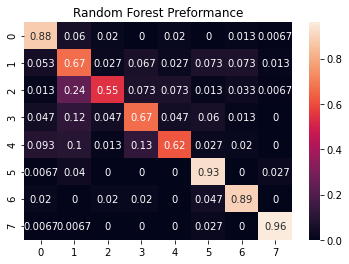

In [10]:
# Confusion Matrics : Verify accuracy of each class
cm = confusion_matrix(y_test_labels, rfc_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True).set_title('Random Forest Preformance')


Text(0.5, 1.0, 'XGB Preformance')

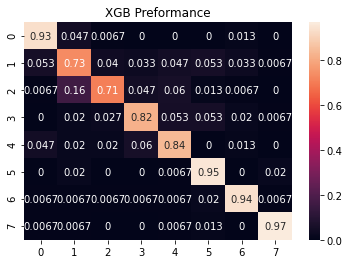

In [11]:
cm = confusion_matrix(y_test_labels, xgb_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True).set_title('XGB Preformance')

In [12]:
# Classification report
print('Random Forest Report : ')
print(classification_report(y_test_labels, rfc_pred))

print('XGB Report : ')
print(classification_report(y_test_labels, xgb_pred))

# save the model
joblib.dump(model, 'hybrid_model.pkl')

Random Forest Report : 
                                                  precision    recall  f1-score   support

                      Test\Tomato_Bacterial_spot       0.79      0.88      0.83       150
                        Test\Tomato_Early_blight       0.54      0.67      0.60       150
                         Test\Tomato_Late_blight       0.81      0.55      0.65       150
                           Test\Tomato_Leaf_Mold       0.70      0.67      0.68       150
                  Test\Tomato_Septoria_leaf_spot       0.79      0.62      0.69       150
Test\Tomato_Spider_mites_Two_spotted_spider_mite       0.79      0.93      0.85       150
      Test\Tomato__Tomato_YellowLeaf__Curl_Virus       0.85      0.89      0.87       150
                             Test\Tomato_healthy       0.95      0.96      0.95       150

                                        accuracy                           0.77      1200
                                       macro avg       0.78      0.77     

['hybrid_model.pkl']

In [ ]:
# Load model from folder
classifier = joblib.load("hybrid_model_rfc.pkl")
img = cv2.imread("C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/6th sem/ML lab/tomato_disease_data/Tomato__Tomato_YellowLeaf__Curl_Virus/0a9e37a2-95d5-4af7-95a1-2cbb67074452___YLCV_NREC 2291.JPG")
cv2.imshow("curl virus",img)
cv2.waitKey(0)
img = cv2.resize(img, (SIZE, SIZE))
img = img/255.0
img = np.array(img)
image = []
image.append(img)
print(np.shape(image))
feature_extractor = vgg_model.predict([image])
# actually our data in the form of (2500, 8, 8, 512) into (2500, 8*8*512) 
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
img_features = features
print(classifier.predict(img_features))

In [12]:
# Load model from file
classifier = joblib.load("hybrid_model.pkl")
# img = cv2.imread("C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/6th sem/ML lab/tomato_disease_data/Test1/Tomato__Tomato_YellowLeaf__Curl_Virus/0a14b65b-2e45-4bed-be45-c482a40a4f7c___UF.GRC_YLCV_Lab 02090.JPG")

# img = cv2.resize(img, (SIZE, SIZE))
# img = img/255.0
# img = np.array(img)
# image = []
# image.append(img)
# print(np.shape(image))
# feature_extractor = vgg_model.predict([image])
# # actually our data in the form of (2500, 8, 8, 512) into (2500, 8*8*512) 
# features = feature_extractor.reshape(feature_extractor.shape[0], -1)
# img_features = features
print(classifier.predict(img_features))


[6]
